# 什麼是趨勢？ #

時間序列的**趨勢**部分表示該序列平均值的持續、長期變化。 趨勢是一序列中移動最慢的部分，代表了最大時間尺度的重要性。 在產品銷售的時間序列中，隨著越來越多的人逐年意識到該產品，市場擴張的影響可能是增加趨勢。

<figure style="padding: 1em;">
<img src="https://i.imgur.com/ZdS4ZoJ.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center>四個時間序列中的趨勢模式</center></figcaption>
</figure>

在本課程中，我們將關注平均值趨勢。 更一般地說，一個序列中任何持續的和緩慢移動的變化都可能構成一個趨勢 —— 例如，時間序列通常在其變化中具有趨勢。

# 移動平均線圖 #

要查看時間序列可能具有什麼樣的趨勢，我們可以使用**移動平均(moving average, MA)圖**。 為了計算時間序列的移動平均值，我們計算某個定義寬度的滑動窗口(sliding window)內的平均值。 圖表上的每個點代表位於任一側窗口內的系列中所有值的平均值。 這個想法是為了**消除序列中的任何短期波動，以便只保留長期變化**。

<figure style="padding: 1em;">
<img src="https://i.imgur.com/EZOXiPs.gif" width=800, alt="An animated plot showing an undulating curve slowly increasing with a moving average line developing from left to right within a window of 12 points (in red).">
<figcaption style="textalign: center; font-style: italic"><center>說明線性趨勢的移動平均線圖。 曲線上的每個點（藍色）是大小為 12 的窗口內的點（紅色）的平均值。
</center></figcaption>
</figure>

請注意上面的 *Mauna Loa* 序列如何年復一年地重複上下運動——一種短期的 *季節性* 變化。 要使變化成為趨勢的一部分，它應該比任何季節性變化發生的時間更長。 因此，為了可視化趨勢，我們在比該序列中的任何季節性週期更長的時間段內取平均值。 對於 *Mauna Loa* 系列，我們選擇了大小為 12 的窗口來平滑每年的季節。

# 趨勢工程

一旦我們確定了趨勢的形狀，我們就可以嘗試使用時間步長特徵對其進行建模。 我們已經看到如何使用時間虛擬模型本身來模擬線性趨勢：

```
目標 = a * 時間 + b
```

我們可以通過時間虛擬變量的轉換來擬合許多其他類型的趨勢。 如果趨勢看起來是二次的（拋物線），我們只需將時間虛擬變量的平方添加到特徵集，得到：
```
目標 = a * 時間 ** 2 + b * 時間 + c
```
線性回歸將學習係數“a”、“b”和“c”。

下圖中的趨勢曲線都是使用這些特徵和 scikit-learn 的 `LinearRegression` 擬合的：

<figure style="padding: 1em;">
<img src="https://i.imgur.com/KFYlgGm.png" width=*00, alt="Above, Cars Sold in Quebec: an undulating plot gradually increasing from 1960-01 to 1968-12 with a linear trend-line superimposed. Below, Plastics Production in Australia: an undulating plot with a concave-up quadratic trend-line superimposed.">
<figcaption style="textalign: center; font-style: italic"><center><strong>上:</strong> 線性的序列趨勢. <strong>下:</strong> 二次方的序列趨勢.
</center></figcaption>
</figure>

如果以前沒有見過這個技巧，那麼可能沒有意識到線性回歸可以擬合除直線以外的曲線。 這個想法是，如果您可以提供適當形狀的曲線作為特徵，那麼線性回歸可以學習如何以最適合目標的方式組合它們。

# 範例 - 隧道流量 #

在此示例中，我們將為 *Tunnel Traffic* 數據集創建一個趨勢模型。

In [2]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Load Tunnel Traffic dataset
data_dir = Path("./data_set/")
tunnel = pd.read_csv(data_dir / "tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period()
tunnel

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569
...,...
2005-11-12,104646
2005-11-13,94424
2005-11-14,112165


讓我們做一個移動平均線圖，看看這個系列有什麼樣的趨勢。 由於這個系列有每日觀察，讓我們選擇一個 365 天的窗口來平滑一年內的任何短期變化。

要創建移動平均線，首先使用“滾動”方法開始窗口計算。 遵循 `mean` 方法來計算窗口上的平均值。 正如我們所見，*Tunnel Traffic* 的趨勢似乎是線性的。

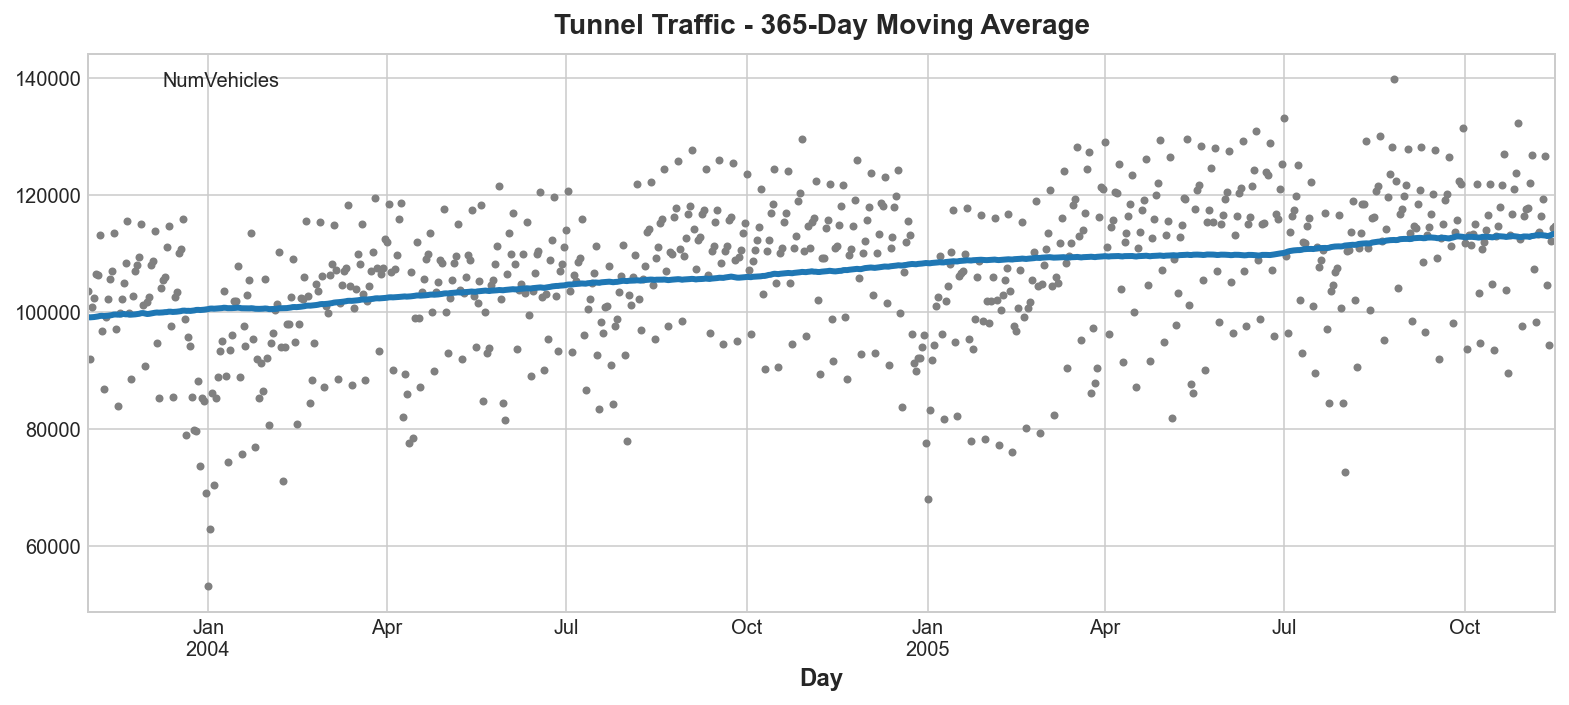

In [14]:
moving_average = tunnel.rolling(
    window=365,       # 365天為單位的滑動窗口
    center=True,      # 將平均數值放在滑動窗口的中間位置
    min_periods=183,  # 選擇大約一半的窗口大小
).mean()              # 計算平均值（也可以計算中位數、標準差、最小值、最大值……）

ax = tunnel.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);

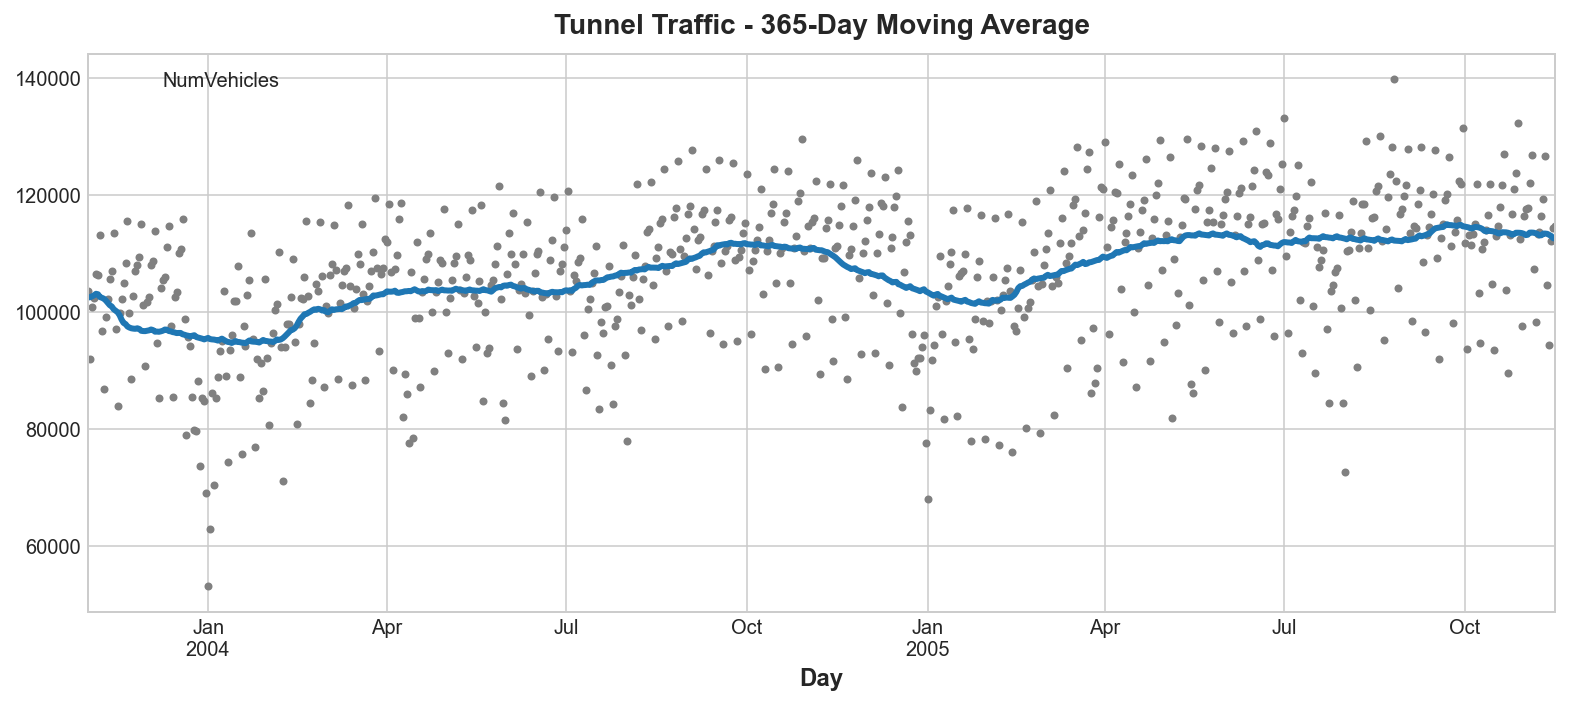

In [18]:
moving_average = tunnel.rolling(
    window=90,       # 365天為單位的滑動窗口
    center=True,      # 將平均數值放在滑動窗口的中間位置
    min_periods=45,  # 選擇大約一半的窗口大小
).mean()              # 計算平均值（也可以計算中位數、標準差、最小值、最大值……）

ax = tunnel.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);

在第 1 課中，我們直接在 Pandas 中設計了我們的時間虛擬變量。 但是，從現在開始，我們將使用 `statsmodels` 庫中的一個名為 `DeterministicProcess` 的函數。 使用這個函數將幫助我們避免一些棘手的失敗案例，這些案例可能會隨著時間序列和線性迴歸而出現。 `order` 參數是指多項式順序：`1` 表示線性，`2` 表示二次，`3` 表示三次，依此類推。

In [9]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=tunnel.index,  # 來自訓練數據的日期
    constant=True,       # 偏差的虛擬特徵（y_intercept）
    order=1,             # 時間虛擬變涼 (trend)
    drop=True,           # 必要時刪除項以避免共線性(collinearity)
)
# `in_sample` 為 `index` 參數中給定的日期創建特徵
X = dp.in_sample()

X.head()

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


（順便說一下， *確定性過程(deterministic process)* 是非隨機或完全*確定*的時間序列的技術術語，就像 `const` 和 `trend` 系列一樣。從時間索引得出的特徵通常會是確定性的。）

我們基本上像以前一樣創建趨勢模型，但請注意添加了 `fit_intercept=False` 參數。

In [10]:
from sklearn.linear_model import LinearRegression

y = tunnel["NumVehicles"]  # the target

# 截距與 DeterministicProcess 中的 `const` 特性相同。 
# LinearRegression 對重複特徵表現不佳，因此我們需要確保在此處排除它。
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

我們的`線性迴歸`模型發現的趨勢幾乎與移動平均圖相同，這表明在這種情況下線性趨勢是正確的決定。

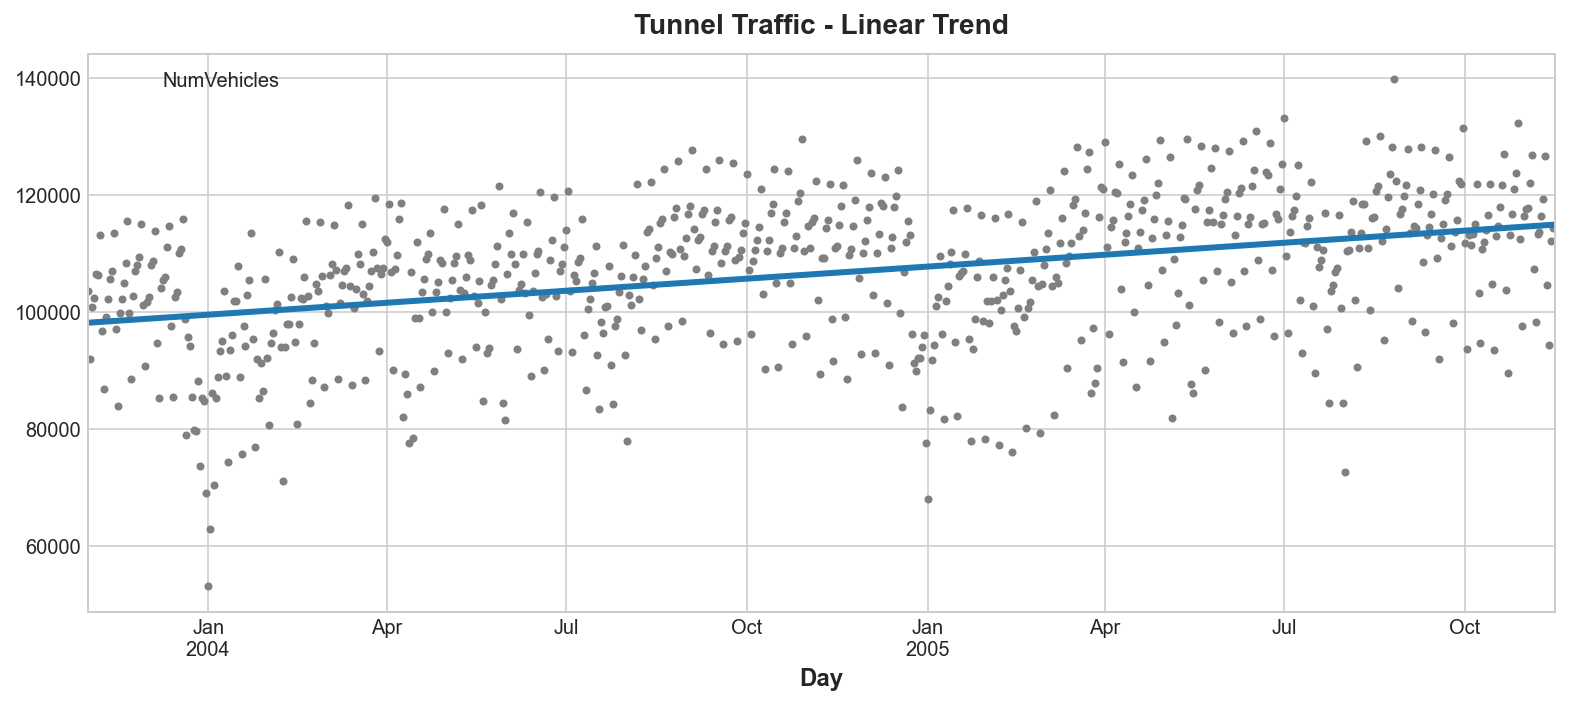

In [11]:
ax = tunnel.plot(style=".", color="0.5", title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

為了進行預測，我們將模型應用於“樣本外(out of sample)”特徵。 “樣本外”是指訓練數據的觀察期之外的時間。 以下是我們如何進行 30 天預測的方法：

In [12]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
Freq: D, dtype: float64

Let's plot a portion of the series to see the trend forecast for the next 30 days:

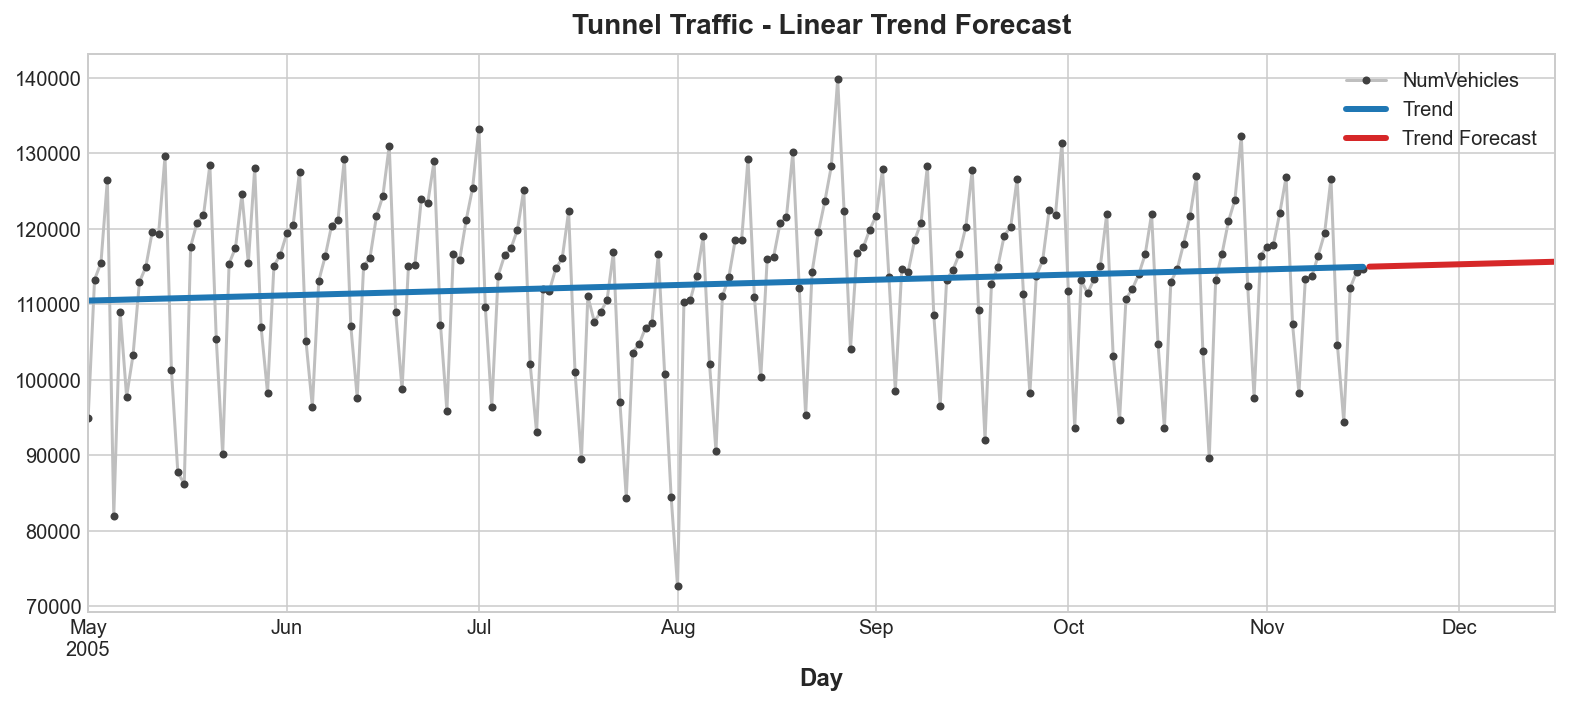

In [13]:
ax = tunnel["2005-05":].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)
ax = y_pred["2005-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

---

我們在本課中學到的趨勢模型之所以有用，有很多原因。 除了作為更複雜模型的基線或起點之外，我們還可以將它們用作“混合模型”中的一個組件，結合無法學習趨勢（如 XGBoost 和隨機森林）的演算法。 我們將在第 5 課中了解有關此技術的更多信息。


### EXERSIZE

[**商店銷售中的模型趨勢**](https://www.kaggle.com/kernels/fork/19616015) 並了解使用高階多項式進行預測的風險。